In [1]:
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import re

In [2]:
def read_data(data_partA, data_allparts, gradrate):
    data_partA = pd.read_csv(data_partA) 
    data_allparts = pd.read_csv(data_allparts)
    data_gradrate = pd.read_csv(gradrate)
    return data_partA, data_allparts, data_gradrate

#Reading the CSV files 
partA, allparts, grad = read_data('../data/ed_data_express/Title1A.csv', '../data/ed_data_express/Title1All.csv', '../data/ed_data_express/GraduationRate.csv')



#Filtering Data in CSV Title 1 Part A
partA = partA.drop(columns = ['Data Description','NCES LEA ID','NCES SCH ID',
                              'Data Group','Denominator', 'Numerator', 
                              'Subgroup', 'Characteristics', 'Age/Grade', 'Academic Subject', 
                              'Program Type', 'Outcome'])
                   

#Filtering data in Title 1 All Parts
allparts = allparts.drop(columns = ['Data Description','NCES LEA ID','NCES SCH ID',
                                    'Data Group','Denominator', 'Numerator', 
                                    'Subgroup', 'Characteristics', 'Age/Grade', 
                                    'Academic Subject', 'Program Type', 'Outcome'])


#Filtering Data is Grad
grad = grad.drop(columns = ['Data Description',
                            'NCES LEA ID','NCES SCH ID','Data Group','Denominator', 'Numerator', 
                            'School', 'Age/Grade', 'Academic Subject', 
                            'Population', 'Outcome', 'Characteristics', 'Program Type'])
grad = grad.drop(grad[(grad['Value'] == '') | (grad['Value'] == 'S')].index)



# Merge the DataFrames
merged_df = pd.merge(partA, allparts, on='LEA', how='inner')
merged_df = pd.merge(merged_df, grad, on='LEA', how='inner')


#Cleaning new dataframe
merged_df = merged_df.drop(columns = ['School_x', 'Population_x', 'School Year_y', 'State_y', 
                                      'Value_y', 'School Year', 'State'])

#Renaming Columns
merged_df = merged_df.rename(columns = {'School Year_x' : 'School Year', 
                                       'State_x' : 'State',
                                       'Value_x' : 'School Improvement Funds',
                                       'Value' : 'Graduation Rates',
                                       'Population_y' : 'School Type',
                                       'School_y' : 'School'})

# Filtering the Columns for Certain Specifications
merged_df = merged_df[merged_df['School'].str.contains(r'\bHigh School\b')]
merged_df = merged_df[~merged_df['School'].str.contains('Junior')]


# Removing duplicate values in the 'Graduation Rates' column
merged_df = merged_df.drop_duplicates(subset=['Graduation Rates'])

#Moving columns around 
merged_df = merged_df[['School Year', 'State', 'LEA', 'School', 'School Type',
                      'Graduation Rates', 'School Improvement Funds', 'Subgroup']]


# Function to remove non-numeric characters
def remove_non_numeric_chars(s):
    return ''.join(filter(lambda x: x.isdigit() or x in ['.', '-'], s))

# Function to convert percentage strings to desired format
def convert_percentage(percentage):
    percentage = remove_non_numeric_chars(percentage)
    try:
        return float(percentage)
    except ValueError:
        if percentage.startswith('>='):
            return float(percentage[2:])
        elif percentage.startswith('<'):
            return min(50.0, float(percentage[1:]))
        elif percentage.startswith('<='):
            return min(10.0, float(percentage[2:]))
        elif '-' in percentage:
            low, high = map(float, percentage.split('-'))
            return (low + high) / 2
    print(f"Unexpected format: {percentage}")
    return 0.0

# Apply the function to the Graduation Rates column
merged_df['Graduation Rates'] = merged_df['Graduation Rates'].apply(convert_percentage)


# List of values to be removed from the 'Subgroup' column
to_remove = ['Black (not Hispanic) African American', 
             'Children with disabilities', 
             'White or Caucasian (not Hispanic)', 
             'Homeless', 
             'Hispanic/Latino', 
             'English Learner', 
             'Multicultural/Multiethnic/Multiracial/other']

# Remove rows based on the values in the 'Subgroup' column
merged_df = merged_df[~merged_df['Subgroup'].isin(to_remove)]

# Function to convert currency strings to float
def convert_currency(val):
    if isinstance(val, str):
        val = val.replace('$', '').replace(',', '')
    try:
        return float(val)
    except ValueError:
        print(f"Unable to convert value: {val}")
        return 0.0

# Apply the function to the 'School Improvement Funds' column
merged_df['School Improvement Funds'] = merged_df['School Improvement Funds'].apply(convert_currency)


# Display the resulting DataFrame
display(merged_df.head())
#merged_df.to_csv(r'merged_dataframe.csv', index=False)

#Display the tables to check the work
display(partA.head())
display(allparts.head())
display(grad.head())

,School Year,State,LEA,School,School Type,Graduation Rates,School Improvement Funds,Subgroup
3311,2020-2021,LOUISIANA,Zachary Community School District,Zachary High School,Title I Schools,96.0,32661.0,All Students in LEA
3329,2020-2021,LOUISIANA,City of Baker School District,Baker High School,Title I Schools,62.0,13222.0,All Students in LEA
3353,2020-2021,LOUISIANA,Office of Juvenile Justice,Riverside Alternative High School,Title I Schools,10.0,81572.0,All Students in LEA
4402,2020-2021,LOUISIANA,Avoyelles Parish,Bunkie Magnet High School,Title I Schools,95.0,116098.0,All Students in LEA
4407,2020-2021,LOUISIANA,Avoyelles Parish,Bunkie Magnet High School,Title I Schools,87.0,116098.0,All Students in School


,School Year,State,LEA,School,Value,Population
0,2020-2021,LOUISIANA,LA Schools for the Deaf and Visually Impaired,Louisiana School for the Deaf,"$58,615",Title I Schools
1,2020-2021,LOUISIANA,Acadia Parish,Armstrong Middle School,"$14,693",Title I Schools
2,2020-2021,LOUISIANA,Acadia Parish,Church Point Middle School,"$14,693",Title I Schools
3,2020-2021,LOUISIANA,Acadia Parish,Crowley Middle School,"$14,693",Title I Schools
4,2020-2021,LOUISIANA,Acadia Parish,Estherwood Elementary School,"$14,692",Title I Schools


,School Year,State,LEA,School,Value,Population
0,2020-2021,LOUISIANA,LA Schools for the Deaf and Visually Impaired,Louisiana School for the Deaf,"$58,615",Title I Schools
1,2020-2021,LOUISIANA,Acadia Parish,Armstrong Middle School,"$14,693",Title I Schools
2,2020-2021,LOUISIANA,Acadia Parish,Church Point Middle School,"$14,693",Title I Schools
3,2020-2021,LOUISIANA,Acadia Parish,Crowley Middle School,"$14,693",Title I Schools
4,2020-2021,LOUISIANA,Acadia Parish,Estherwood Elementary School,"$14,692",Title I Schools


,School Year,State,LEA,Value,Subgroup
0,2020-2021,LOUISIANA,Louisiana School for Math Science & the Arts,>=95%,All Students in LEA
2,2020-2021,LOUISIANA,Louisiana School for Math Science & the Arts,>=80%,Asian/Pacific Islander
3,2020-2021,LOUISIANA,Louisiana School for Math Science & the Arts,>=50%,Black (not Hispanic) African American
4,2020-2021,LOUISIANA,Louisiana School for Math Science & the Arts,>=50%,Hispanic/Latino
5,2020-2021,LOUISIANA,Louisiana School for Math Science & the Arts,>=95%,White or Caucasian (not Hispanic)


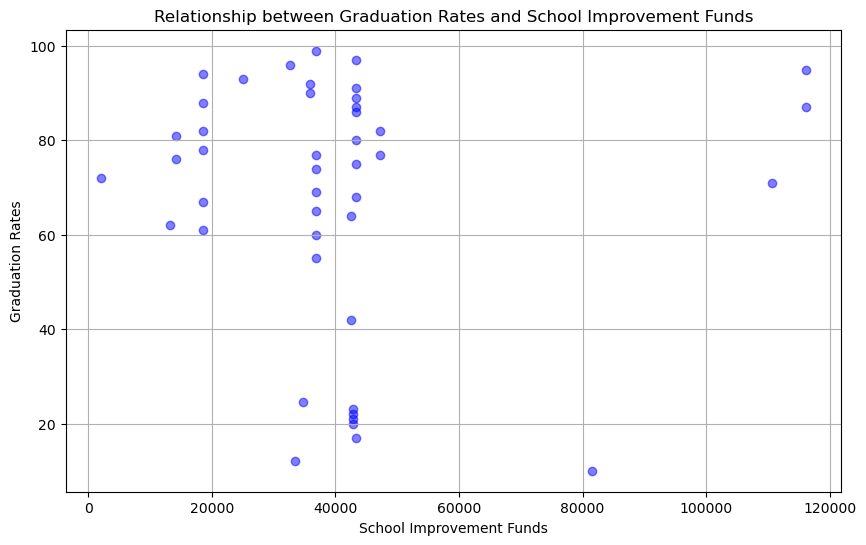

In [3]:
# Plotting the linear relationship
plt.figure(figsize=(10,6))
plt.scatter(merged_df['School Improvement Funds'], merged_df['Graduation Rates'], color='b', alpha=0.5)
plt.title('Relationship between Graduation Rates and School Improvement Funds')
plt.xlabel('School Improvement Funds')
plt.ylabel('Graduation Rates')
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('ed_data_express_visualizations/relationship.png', dpi=300, bbox_inches='tight')
plt.show()

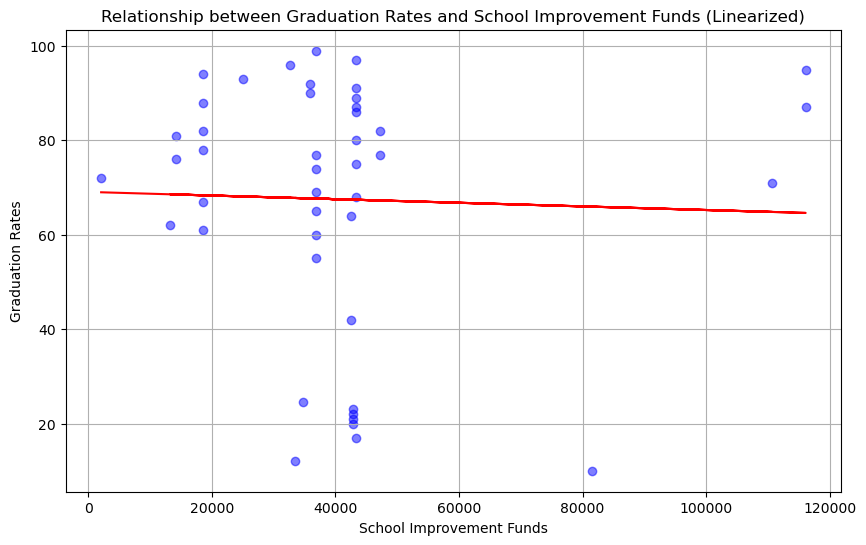

In [4]:
from sklearn.linear_model import LinearRegression

# Plotting the linear relationship
plt.figure(figsize=(10,6))
plt.scatter(merged_df['School Improvement Funds'], merged_df['Graduation Rates'], color='b', alpha=0.5)
plt.title('Relationship between Graduation Rates and School Improvement Funds (Linearized)')
plt.xlabel('School Improvement Funds')
plt.ylabel('Graduation Rates')
plt.grid(True)

# Perform linear regression
X = np.array(merged_df['School Improvement Funds']).reshape(-1, 1)
y = np.array(merged_df['Graduation Rates'])
model = LinearRegression()
model.fit(X, y)

# Plot the linear regression line
plt.plot(X, model.predict(X), color='r')
# Save the plot as a PNG file
plt.savefig('ed_data_express_visualizations/linear_plot.png', dpi=300, bbox_inches='tight')

plt.show()



In [5]:
# Convert the 'Graduation Rates' column to numeric
merged_df['Graduation Rates'] = pd.to_numeric(merged_df['Graduation Rates'])

# Sort the DataFrame by 'Graduation Rates' in descending order
merged_df.sort_values('Graduation Rates', ascending=False, inplace=True)

# Drop duplicates based on the 'School' column, keeping the first occurrence (highest 'Graduation Rate')
merged_df.drop_duplicates(subset='School', keep='first', inplace=True)

display(merged_df.head())
#merged_df.to_csv(r'merged_dataframe highest grad.csv', index=False)

,School Year,State,LEA,School,School Type,Graduation Rates,School Improvement Funds,Subgroup
152208,2020-2021,LOUISIANA,East Baton Rouge Parish,Belaire High School,Title I Schools,99.0,36849.0,All Students in School
15046,2020-2021,LOUISIANA,Caddo Parish,Huntington High School,Title I Schools,97.0,43346.0,All Students in School
3311,2020-2021,LOUISIANA,Zachary Community School District,Zachary High School,Title I Schools,96.0,32661.0,All Students in LEA
4402,2020-2021,LOUISIANA,Avoyelles Parish,Bunkie Magnet High School,Title I Schools,95.0,116098.0,All Students in LEA
336010,2020-2021,LOUISIANA,Jefferson Parish,Bonnabel Magnet Academy High School,Title I Schools,94.0,18514.0,All Students in School


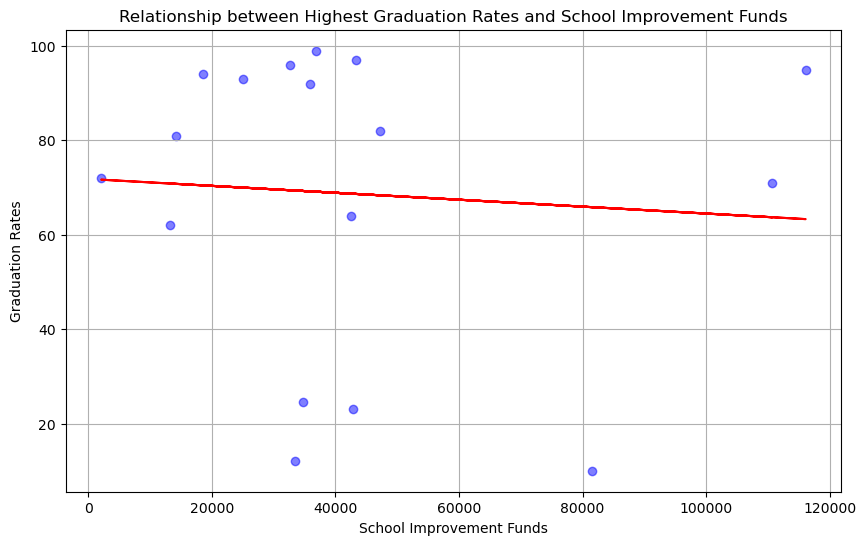

In [6]:
from sklearn.linear_model import LinearRegression

# Plotting the linear relationship
plt.figure(figsize=(10,6))
plt.scatter(merged_df['School Improvement Funds'], merged_df['Graduation Rates'], color='b', alpha=0.5)
plt.title('Relationship between Highest Graduation Rates and School Improvement Funds')
plt.xlabel('School Improvement Funds')
plt.ylabel('Graduation Rates')
plt.grid(True)

# Perform linear regression
X = np.array(merged_df['School Improvement Funds']).reshape(-1, 1)
y = np.array(merged_df['Graduation Rates'])
model = LinearRegression()
model.fit(X, y)

# Plot the linear regression line
plt.plot(X, model.predict(X), color='r')
# Save the plot as a PNG file
plt.savefig('ed_data_express_visualizations/Linear_Plot_Highest_Grad.png', dpi=300, bbox_inches='tight')

plt.show()



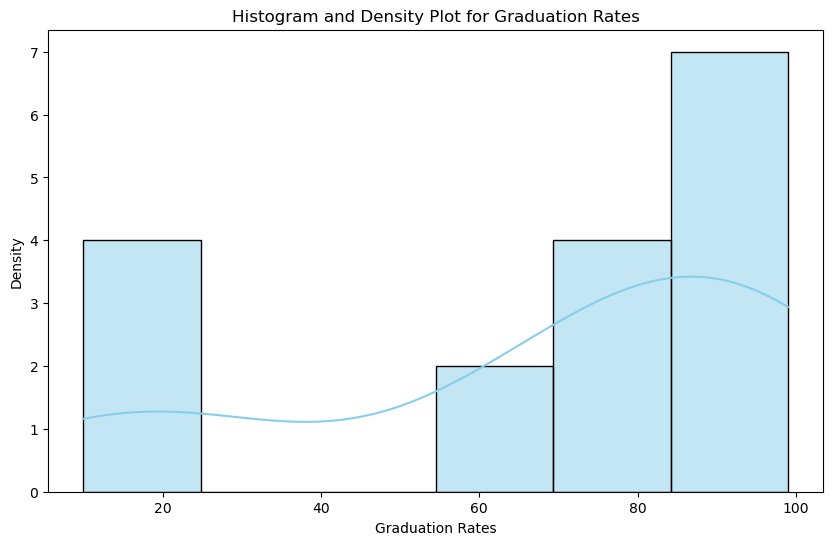

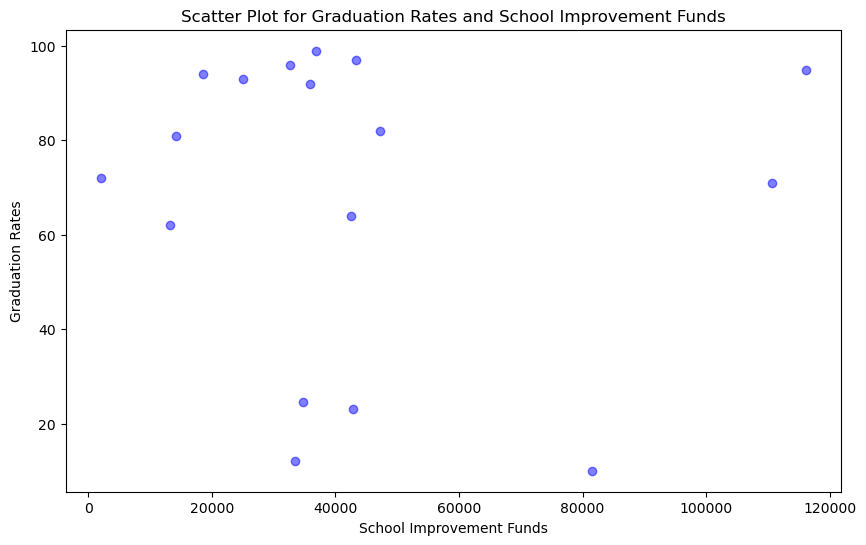

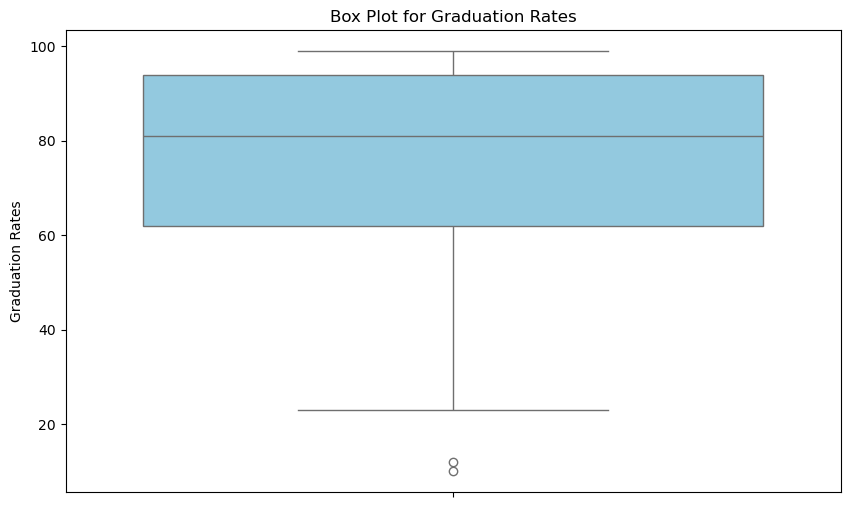

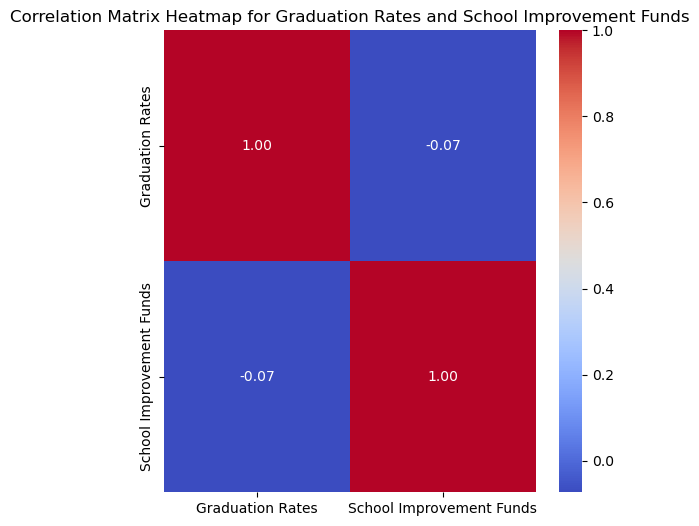

C:\Users\swpea\anaconda3\envs\AIPI510\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

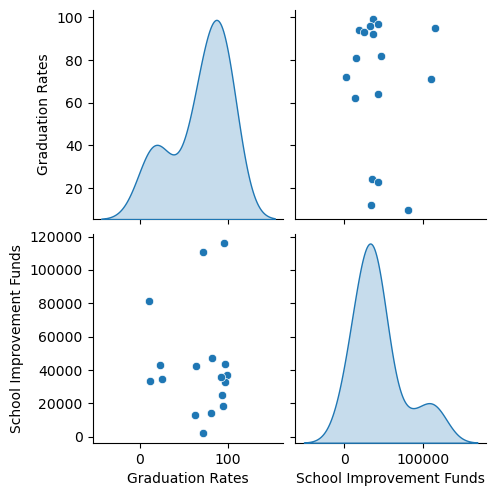

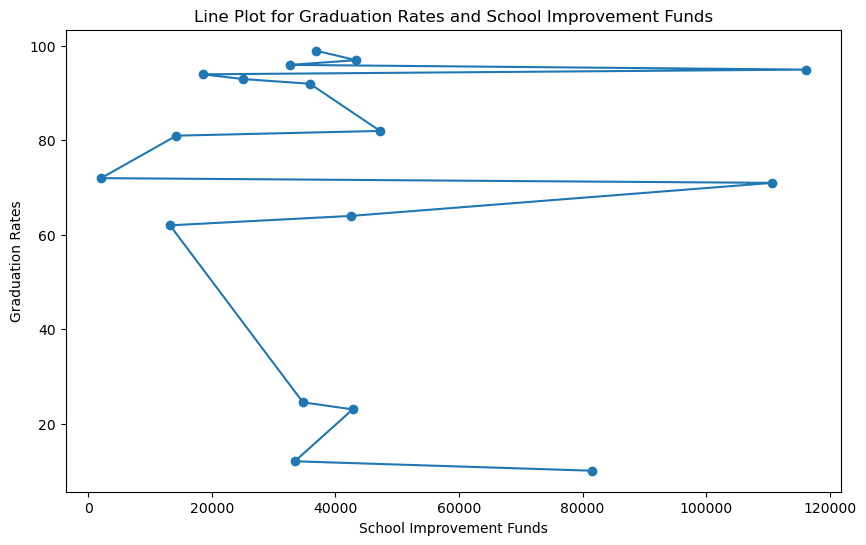

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms and Density Plots
plt.figure(figsize=(10,6))
sns.histplot(merged_df['Graduation Rates'], kde=True, color='skyblue')
plt.title('Histogram and Density Plot for Graduation Rates')
plt.xlabel('Graduation Rates')
plt.ylabel('Density')
plt.savefig('ed_data_express_visualizations/Density.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(merged_df['School Improvement Funds'], merged_df['Graduation Rates'], color='b', alpha=0.5)
plt.title('Scatter Plot for Graduation Rates and School Improvement Funds')
plt.xlabel('School Improvement Funds')
plt.ylabel('Graduation Rates')
plt.savefig('ed_data_express_visualizations/ScatterPlot.png', dpi=300, bbox_inches='tight')
plt.show()

# Box Plot
plt.figure(figsize=(10,6))
sns.boxplot(y=merged_df['Graduation Rates'], color='skyblue')
plt.title('Box Plot for Graduation Rates')
plt.ylabel('Graduation Rates')
plt.savefig('ed_data_express_visualizations/BoxPlot.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(merged_df[['Graduation Rates', 'School Improvement Funds']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap for Graduation Rates and School Improvement Funds')
plt.savefig('ed_data_express_visualizations/Correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Pair Plot
plt.figure(figsize=(10,6))
sns.pairplot(merged_df[['Graduation Rates', 'School Improvement Funds']], kind='scatter', diag_kind='kde')
plt.savefig('ed_data_express_visualizations/pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Line Plot
plt.figure(figsize=(10,6))
plt.plot(merged_df['School Improvement Funds'], merged_df['Graduation Rates'], marker='o', linestyle='-')
plt.title('Line Plot for Graduation Rates and School Improvement Funds')
plt.xlabel('School Improvement Funds')
plt.ylabel('Graduation Rates')
plt.savefig('ed_data_express_visualizations/Line.png', dpi=300, bbox_inches='tight')
plt.show()
